In [516]:
from proxmin import nmf
from proxmin.utils import Traceback
from scipy.optimize import linear_sum_assignment
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt
import time
from proxmin import operators as po
from functools import partial

In [517]:
data = np.load("hsc_stacked.npy")

In [518]:
redshifts = data['z_cl']

# Bin the cluster data by redshift
clusters1 = data[(redshifts > 0.1) & (redshifts < 0.2)]
clusters2 = data[(redshifts > 0.2) & (redshifts < 0.35)]
clusters3 = data[(redshifts > 0.35) & (redshifts < 0.5)]
clusters4 = data[(redshifts > 0.5) & (redshifts < 0.75)]
clusters5 = data[(redshifts > 0.75) & (redshifts < 1.2)]

In [519]:
num_radial_bins = 15

In [520]:
# Compute the average colors (and their variances) for a given redshift bin

def get_clusters_data(clusters):
    
    clusters = clusters[np.where(clusters['R'] > 0.015)]
    radii = np.array(clusters['R'])
    
    # Arrays containing magnitude data in four different filters
    g = np.array(clusters['gmag_forced_cmodel'])
    r = np.array(clusters['rmag_forced_cmodel'])
    i = np.array(clusters['imag_forced_cmodel'])
    z = np.array(clusters['zmag_forced_cmodel'])
    
    g_pruned = g[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    r_pruned = r[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    i_pruned = i[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    z_pruned = z[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]

    radii_pruned = radii[np.isfinite(g) & np.isfinite(r) & np.isfinite(i) & np.isfinite(z)]
    radial_bins = np.logspace(np.log10(np.amin(radii_pruned)), np.log10(np.amax(radii_pruned)), num_radial_bins + 1)
    widths = np.diff(radial_bins)
    annular_areas = np.pi * np.diff(radial_bins ** 2.)

    
    # For each color g-r, r-i, and i-z: first, throw out data points that have magnitudes of "nan" or "inf" (pruning the
    # arrays of radii and magnitudes accordingly), then use scipy.binned_statistic to sort the data into radial bins and
    # compute the number of objects and the sum and variance (noise^2) of the color values in those bins

    
    gr = g_pruned - r_pruned
    counts = binned_statistic(radii_pruned, gr, 'count', radial_bins)[0]
    sum_gr = binned_statistic(radii_pruned, gr, 'sum', radial_bins)[0]
    var_gr = binned_statistic(radii_pruned, gr, np.var, radial_bins)[0]
    var_gr *= counts

    ri = r_pruned - i_pruned
    sum_ri = binned_statistic(radii_pruned, ri, 'sum', radial_bins)[0]
    var_ri = binned_statistic(radii_pruned, ri, np.var, radial_bins)[0]
    var_ri *= counts

    iz = i_pruned - z_pruned
    sum_iz = binned_statistic(radii_pruned, iz, 'sum', radial_bins)[0]
    var_iz = binned_statistic(radii_pruned, iz, np.var, radial_bins)[0]
    var_iz *= counts

    # Compute the mean and variance of the i magnitudes over the same radial bins as above
    
    sum_i = binned_statistic(radii_pruned, i_pruned, 'sum', radial_bins)[0]
    var_i = binned_statistic(radii_pruned, i_pruned, np.var, radial_bins)[0]
    var_i *= counts
    
    return (radial_bins, widths, annular_areas, counts, (sum_i, var_i), (sum_gr, var_gr), (sum_ri, var_ri), (sum_iz, var_iz))

In [521]:
# Plot bar graphs for the average color data in a given redshift bin

def plot_profiles(clusters, z_bin_num, area_normalization=True):
    
    clusters_data = get_clusters_data(clusters)

    radial_bins = clusters_data[0]
    widths = clusters_data[1]
    annular_areas = clusters_data[2]
    counts = clusters_data[3]
    
    # i, gr, ri, iz, are 2-tuples of the form (sum_color, var_color)
    i = clusters_data[4]
    gr = clusters_data[5]
    ri = clusters_data[6]
    iz = clusters_data[7]
    
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")
    
    if(area_normalization):
        plt.bar(radial_bins[:-1], gr[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(gr[1]/annular_areas**2.))
        plt.xscale('log')
        plt.title("g-r Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{g-r}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.show()

        plt.bar(radial_bins[:-1], ri[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(ri[1]/annular_areas**2.))
        plt.xscale('log')
        plt.title("r-i Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{r-i}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.show()

        plt.bar(radial_bins[:-1], iz[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(iz[1]/annular_areas**2.))
        plt.xscale('log')
        plt.title("i-z Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{i-z}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.show()

        plt.bar(radial_bins[:-1], i[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(i[1]/annular_areas**2.))
        plt.xscale('log')
        plt.title("i-filter Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{i}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.show()
        
        plt.bar(radial_bins[:-1], counts/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(counts/annular_areas**2.))
        plt.xscale('log')
        plt.title("Galaxy Number Density vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"Number Density $[\frac{counts}{Mpc^2}]$")
        plt.show()

    else:
        plt.bar(radial_bins[:-1], gr[0]/counts, width=widths, fill=False, align="edge", yerr=np.sqrt(gr[1]))
        plt.xscale('log')
        plt.title("Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel("Average g-r [magnitudes]")
        plt.show()

        plt.bar(radial_bins[:-1], ri[0]/counts, width=widths, fill=False, align="edge", yerr=np.sqrt(ri[1]))
        plt.xscale('log')
        plt.title("Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel("Average r-i [magnitudes]")
        plt.show()

        plt.bar(radial_bins[:-1], iz[0]/counts, width=widths, fill=False, align="edge", yerr=np.sqrt(iz[1]))
        plt.xscale('log')
        plt.title("Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel("Average i-z [magnitudes]")
        plt.show()

        plt.bar(radial_bins[:-1], i[0]/counts, width=widths, fill=False, align="edge", yerr=np.sqrt(i[1]))
        plt.xscale('log')
        plt.title("Average i-filter Magnitude vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel("Average i [magnitudes]")
        plt.show()
    
    return clusters_data

In [522]:
# Use NMF to unmix the color profiles generated by plot_profiles and avg_colors
# The arguments of "unmix" are 2-tuples of the form (mean_color, var_color). For example, gr is really (mean_gr, var_gr)

def prox_field(S, step):
    S[0, :] = 1
    S[1:, :] /= S[1:,:].max(axis=1)[:,None]
    return S

def unmix(counts, i, gr, ri, iz, annular_areas):
    n = num_radial_bins     # component resolution
    k = 2                   # number of components
    b = 5                   # number of observations (b=5 for counts, i, g-r, r-i, and i-z)

    # Data matrix to be unmixed
    Y = np.array([counts, i[0], gr[0], ri[0], iz[0]]) / annular_areas
    
    # if noise is variable, specify variance matrix of the same shape as Y
    W = 1. / (np.array([counts, i[1], gr[1], ri[1], iz[1]]) / annular_areas**2)

    # initialize and run NMF
    A = np.random.uniform(size = (b, k))
    S = np.random.uniform(size = (k, n))
    pA = po.prox_id
    
    pS = po.AlternatingProjections([prox_field, po.prox_plus])
    
    nmf(Y, A, S, W=W, prox_A=pA, prox_S=pS, e_rel=1e-6, e_abs=0)
    
    return A, S

In [523]:
def plot_factorized_profiles(clusters_data, z_bin_num, area_normalization=True):
    

    radial_bins = clusters_data[0]
    bin_midpoints = (radial_bins[1:] * radial_bins[:-1]) ** 0.5
    widths = clusters_data[1]
    annular_areas = clusters_data[2]
    counts = clusters_data[3]
    
    # i, gr, ri, iz, are 2-tuples of the form (sum_color, var_color)
    i = clusters_data[4]
    gr = clusters_data[5]
    ri = clusters_data[6]
    iz = clusters_data[7]
    
    
    A, S = unmix(counts, i, gr, ri, iz, annular_areas)
    print("A:\n", A, "\n")
    print("S:\n", S, "\n")
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")
    
    # Plot S_k (the relative abundance of the kth component) vs. radius for each k
    
    for k in range(S.shape[0]):
        plt.plot(bin_midpoints, S[k], label = "Component %s" % (k+1))
    plt.xscale('log')
    plt.title("Relative Component Abundance vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel("Relative abundance")
    plt.legend()
    plt.show()
    

    Y_remixed = np.dot(A, S)
    
    # Plot the reconstructed color profiles following NMF 
    # (that is, plot Y_remixed = A x S, where A and S are the results of factorizing the initial data matrix Y)
    
    if(area_normalization):
        
        plt.bar(radial_bins[:-1], counts/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(counts/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[0], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Galaxy Number Density vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"Number Density $[\frac{counts}{Mpc^2}]$")
        plt.legend()
        plt.show()
        
        plt.bar(radial_bins[:-1], i[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(i[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[1], label="Predicted Profile")
        plt.xscale('log')
        plt.title("i-filter Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{i}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()
        
        plt.bar(radial_bins[:-1], gr[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(gr[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[2], label="Predicted Profile")
        plt.xscale('log')
        plt.title("g-r Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{g-r}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], ri[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(ri[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[3], label="Predicted Profile")
        plt.xscale('log')
        plt.title("r-i Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{r-i}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], iz[0]/annular_areas, width=widths, fill=False, align="edge", 
                yerr=np.sqrt(iz[1]/annular_areas**2.), label="Data")
        plt.plot(bin_midpoints, Y_remixed[4], label="Predicted Profile")
        plt.xscale('log')
        plt.title("i-z Surface Brightness vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel(r"$\frac{i-z}{Area} [\frac{magnitudes}{Mpc^2}]$")
        plt.legend()
        plt.show()

        
    else:
        plt.bar(radial_bins[:-1], clusters_data[2][0], width=widths, align="edge", alpha=0.5, edgecolor='black', 
                yerr=np.sqrt(clusters_data[2][1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[0], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average g-r [magnitudes]")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], clusters_data[3][0], width=widths, align="edge", alpha=0.5, edgecolor='black', 
                yerr=np.sqrt(clusters_data[3][1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[1], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average r-i [magnitudes]")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], clusters_data[4][0], width=widths, align="edge", alpha=0.5, edgecolor='black', 
                yerr=np.sqrt(clusters_data[4][1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[2], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average i-z [magnitudes]")
        plt.legend()
        plt.show()

        plt.bar(radial_bins[:-1], clusters_data[5][0], width=widths, align="edge", alpha=0.5, edgecolor='black', 
                yerr=np.sqrt(clusters_data[5][1]), label="Data")
        plt.plot(bin_midpoints, Y_remixed[3], label="Predicted Profile")
        plt.xscale('log')
        plt.title("Average i-filter Magnitude vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
        plt.xlabel("Radius from cluster center [Mpc]")
        plt.ylabel ("Average i [magnitudes]")
        plt.legend()
        plt.show()
    

In [524]:
#Plot bar graphs for the clusters1 data

clusters1_data = get_clusters_data(clusters1)

A:
 [[  11333.22155493   -4328.781225  ]
 [ 264586.93077642 -104288.00754467]
 [   9094.98459436   -4250.85929598]
 [   5583.06901367   -2019.51070444]
 [   3896.81305834   -1695.25210597]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 0.96071757  0.          0.08747762  0.5035062   0.66107933  0.56676798
   0.86414999  0.89669765  0.77697361  1.          0.85784301  0.92403933
   0.79002359  0.69500816  0.60157465]] 



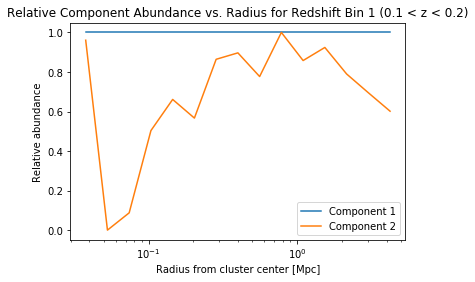

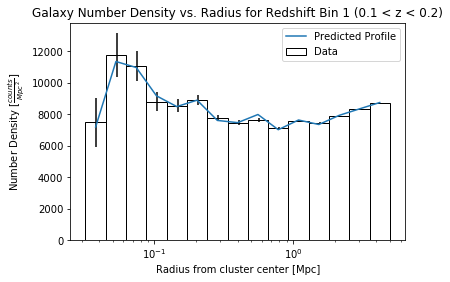

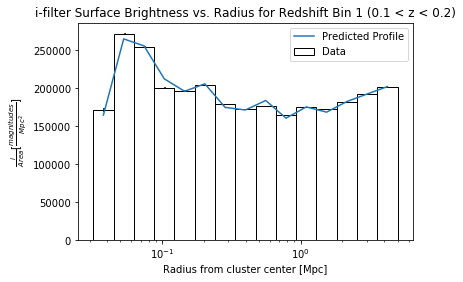

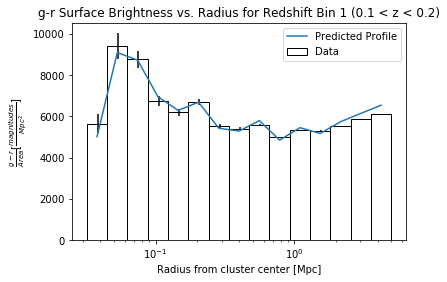

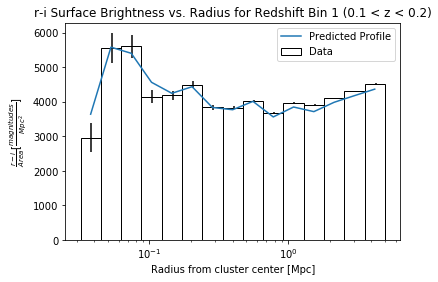

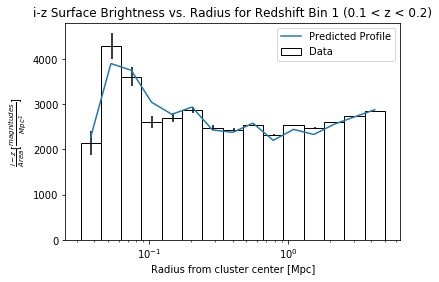

In [525]:
#Plot bar graphs for the post-NMF clusters1 profiles

plot_factorized_profiles(clusters1_data, 1, area_normalization=True)

In [527]:
#Plot bar graphs for the clusters2 data

clusters2_data = get_clusters_data(clusters2)

A:
 [[  25517.2796523   -21071.10375077]
 [ 578865.64751799 -468889.40333409]
 [  20935.25101769  -17943.93019454]
 [  12560.40424411  -10006.53464364]
 [   7606.17336095   -5393.95653506]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          0.69431738  0.42269678  0.08102544  0.03209196  0.17071025
   0.25381631  0.28028151  0.34700479  0.3906644   0.45389679  0.46585536
   0.46308537  0.46327416  0.49709439]] 



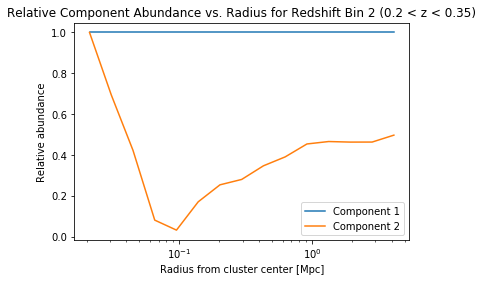

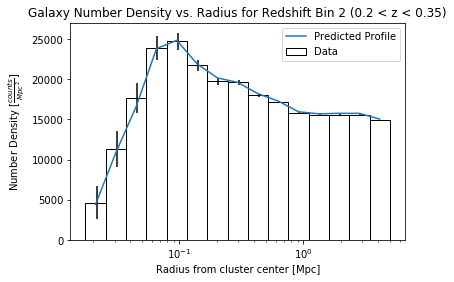

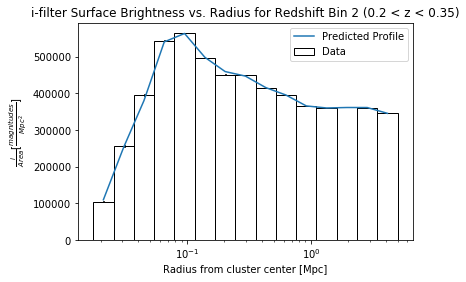

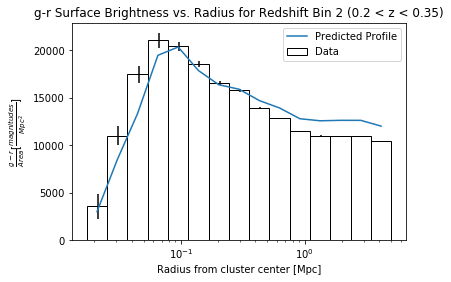

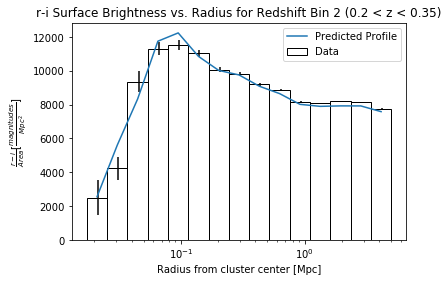

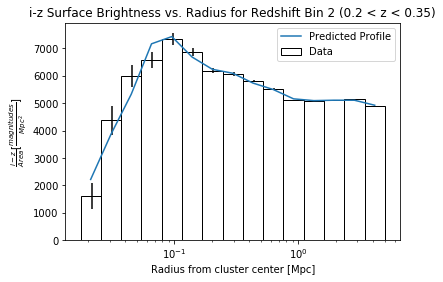

In [528]:
#Plot bar graphs for the post-NMF clusters2 profiles

plot_factorized_profiles(clusters2_data, 2, area_normalization=True)

In [529]:
#Plot bar graphs for the clusters3 data

clusters3_data = get_clusters_data(clusters3)

A:
 [[   8509.05742706   -3503.11889795]
 [ 190458.75803014  -71225.70989676]
 [   9273.90396139   -6363.65777442]
 [   4950.27910574   -2497.77099789]
 [   2959.87587749   -1314.75365029]] 

S:
 [[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  1.19996287e-01   1.00551559e-05   6.94721548e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.11133477e-02   9.33458038e-02
    3.72395765e-01   4.33560648e-01   5.80606322e-01   6.87523482e-01
    1.00000000e+00   9.77501043e-01   9.24904922e-01]] 



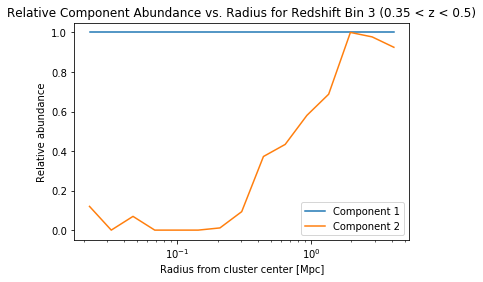

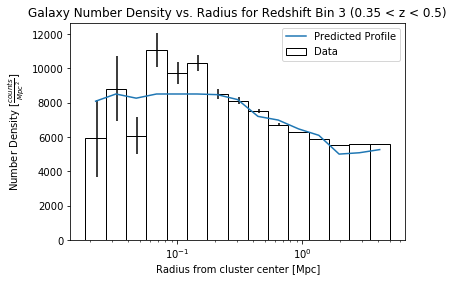

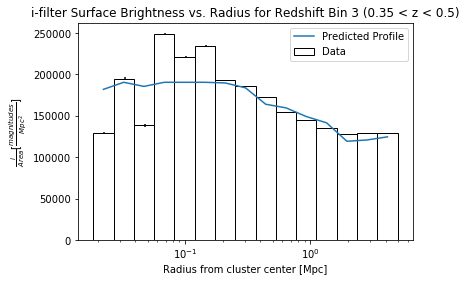

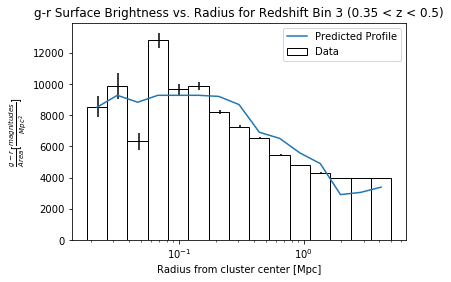

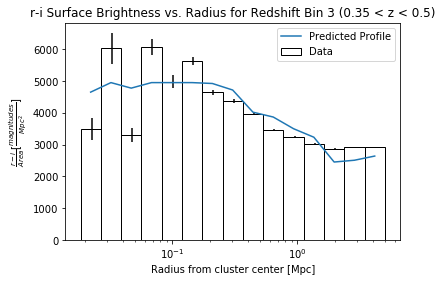

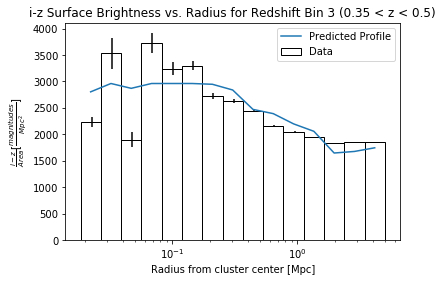

In [530]:
#Plot bar graphs for the post-NMF clusters3 profiles

plot_factorized_profiles(clusters3_data, 3, area_normalization=True)

In [531]:
#Plot bar graphs for the clusters4 data

clusters4_data = get_clusters_data(clusters4)

A:
 [[   6639.96830276   -4863.95001578]
 [ 150449.68504512 -108633.54241634]
 [   7371.88979591   -6455.99721034]
 [   5442.78839843   -4703.63533449]
 [   2522.49643793   -2035.80465819]] 

S:
 [[ 1.          1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.          1.          1.
   1.        ]
 [ 1.          0.23885488  0.06127825  0.          0.14105114  0.1194036
   0.31514448  0.5148232   0.57230681  0.66282342  0.72323659  0.75888794
   0.74650823  0.76090944  0.75728972]] 



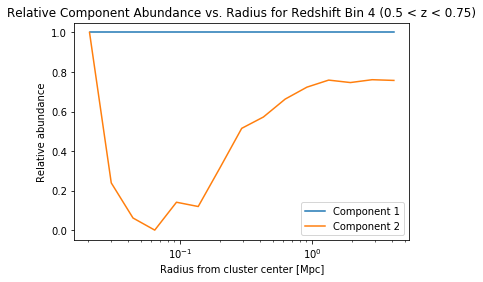

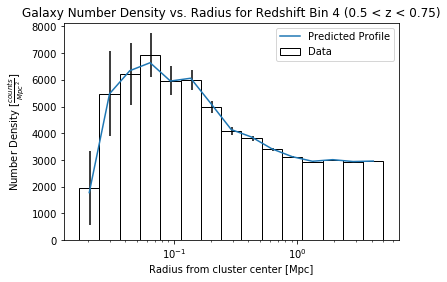

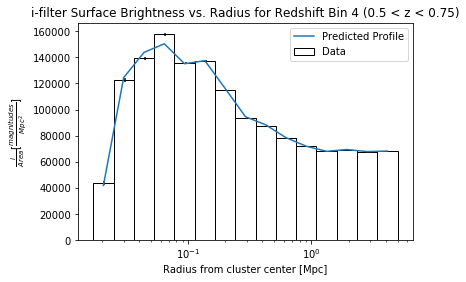

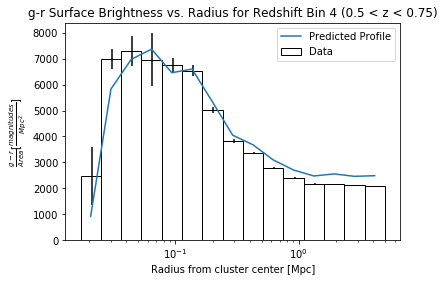

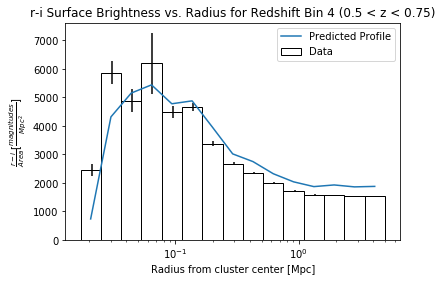

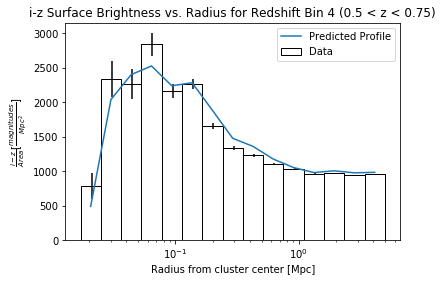

In [532]:
#Plot bar graphs for the post-NMF clusters4 profiles

plot_factorized_profiles(clusters4_data, 4, area_normalization=True)

In [533]:
#Plot bar graphs for the clusters5 data

clusters5_data = get_clusters_data(clusters5)

A:
 [[  4170.4541315   -2333.67181493]
 [ 92082.7113635  -53313.41412156]
 [  4385.64483854  -2999.18759108]
 [  3429.61464107  -3059.78279366]
 [  2018.64253345  -1808.26032668]] 

S:
 [[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00]
 [  7.51926975e-04   7.12651840e-05   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.46233439e-05   2.00813419e-02
    1.81116281e-01   1.24830250e-01   4.55479473e-01   1.00000000e+00
    6.46808632e-01   6.42561981e-01   6.80016965e-01]] 



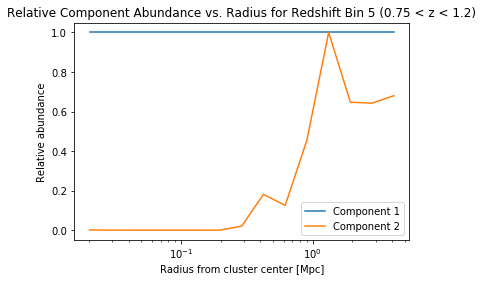

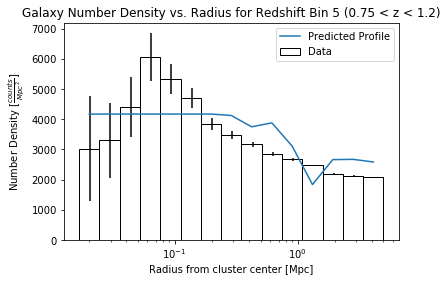

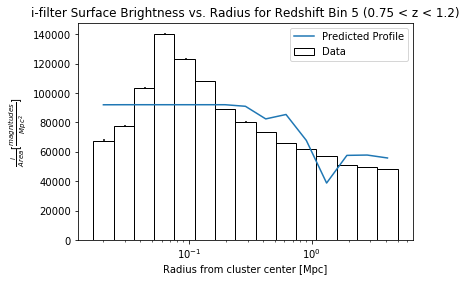

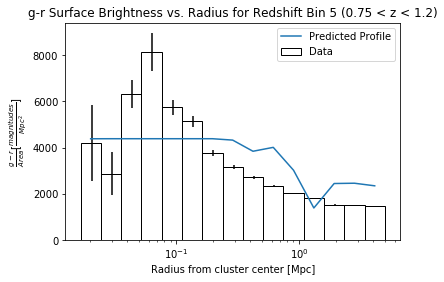

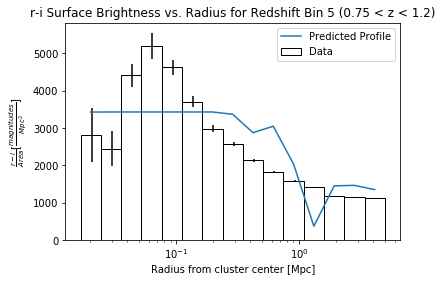

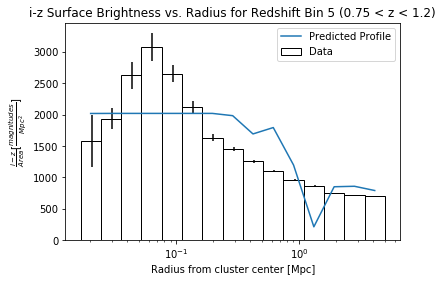

In [535]:
#Plot bar graphs for the post-NMF clusters5 profiles

plot_factorized_profiles(clusters5_data, 5, area_normalization=True)